# **1. Daten einlesen**
In diesem Schritt lesen wir alle `.jl`-Dateien aus dem Verzeichnis `../twitter-bundestag-2022/data/` ein, extrahieren die Tweet-Texte und die zugehörige Partei, und speichern die Daten als CSV-Datei für die weitere Verarbeitung.

In [5]:
# Code aus 01_read_data.py

import json
import glob
import pandas as pd

# List to collect all tweets
all_data = []

# Iterate through all .jl files in the data folder
for filepath in glob.glob("../twitter-bundestag-2022/data/*.jl"):
    with open(filepath, "r", encoding="utf-8") as file:
        partei = None

        for line in file:
            entry = json.loads(line)

            # Extract party from account_data, usually in the first line
            if not partei and "account_data" in entry:
                partei = entry["account_data"].get("Partei", "Unbekannt")

            # Extract tweets from lines with "response"
            if "response" in entry:
                tweets = entry["response"].get("data", [])
                for tweet in tweets:
                    text = tweet.get("text", "")
                    if text:
                        all_data.append({
                            "text": text,
                            "partei": partei
                        })


In [6]:
# Create DataFrame
df = pd.DataFrame(all_data)

# Show basic info
print(f"Tweets insgesamt: {len(df)}")
print("Spalten:", df.columns.tolist())
if not df.empty:
    print(df.sample(5, random_state=1))

# Show party distribution
print("\nTweets pro Partei:")
print(df["partei"].value_counts())

# Save to CSV
df.to_csv("tweets_bundestag.csv", index=False, encoding="utf-8-sig")
print("CSV gespeichert unter: tweets_bundestag.csv")

Tweets insgesamt: 3801087
Spalten: ['text', 'partei']
                                                      text  \
1856936  RT @SenWiEnBe: Auch die neuen Zahlen belegen: ...   
814722   @handelsblatt Wenn dem #Bundeskanzler „besonde...   
3239937     Mein Weg zur Arbeit ... http://t.co/C2sgbwBOtX   
2352165  Falsche Behauptungen über Personen sind heute ...   
3502626  Bühne frei für allerlei😲, auch in Orientalen.....   

                        partei  
1856936  Bündnis 90/Die Grünen  
814722                     CDU  
3239937                    SPD  
2352165              Die Linke  
3502626                    AfD  

Tweets pro Partei:
partei
Bündnis 90/Die Grünen    922789
SPD                      794275
CDU                      623217
Die Linke                540002
FDP                      383721
AfD                      281167
CSU                      168803
Fraktionslos              87113
Name: count, dtype: int64
CSV gespeichert unter: tweets_bundestag.csv


## **2. Baseline-Modell**
Wir erstellen ein erstes Modell nur auf Basis des unbearbeiteten Tweet-Textes.  
Ziel ist es, eine einfache Vergleichsbasis zu schaffen.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Filter out unknown or too-small parties
min_tweet_count = 1000
valid_parties = df["partei"].value_counts()[df["partei"].value_counts() >= min_tweet_count].index
df = df[df["partei"].isin(valid_parties) & (df["partei"] != "Unbekannt")]

# Optional: Downsample if dataset is huge
max_samples = 50000
if len(df) > max_samples:
    df = df.sample(n=max_samples, random_state=42)

print(f"Verbleibende Parteien: {df['partei'].unique()}")
print("Tweets pro Partei im Sample:\n", df["partei"].value_counts())


Verbleibende Parteien: ['CDU' 'Die Linke' 'SPD' 'Bündnis 90/Die Grünen' 'FDP' 'CSU' 'AfD'
 'Fraktionslos']
Tweets pro Partei im Sample:
 partei
Bündnis 90/Die Grünen    12205
SPD                      10496
CDU                       8206
Die Linke                 7117
FDP                       5030
AfD                       3637
CSU                       2195
Fraktionslos              1114
Name: count, dtype: int64


In [8]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["partei"],
    test_size=0.2,
    random_state=42,
    stratify=df["partei"]
)

# TF-IDF vectorization (keep hashtags, mentions, emojis, URLs for now)
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Logistic Regression baseline
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_vec, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [9]:
# Evaluation
y_pred = clf.predict(X_test_vec)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                        precision    recall  f1-score   support

                  AfD      0.490     0.579     0.531       727
Bündnis 90/Die Grünen      0.564     0.402     0.469      2441
                  CDU      0.468     0.395     0.429      1641
                  CSU      0.209     0.449     0.285       439
            Die Linke      0.421     0.450     0.435      1424
                  FDP      0.404     0.406     0.405      1006
         Fraktionslos      0.072     0.287     0.115       223
                  SPD      0.492     0.388     0.434      2099

             accuracy                          0.417     10000
            macro avg      0.390     0.419     0.388     10000
         weighted avg      0.465     0.417     0.432     10000


Confusion Matrix:
 [[421  34  38  43  47  37  66  41]
 [114 981 210 175 329 172 190 270]
 [ 73 158 649 157 129 125 143 207]
 [ 14  40  68 197  33  14  28  45]
 [ 55 187  87 106 641  77 124 147]
 [ 55 100  83  65  98

## **3. Explorative Datenanalyse**
Wir untersuchen grundlegende Eigenschaften des Datensatzes. Die Einblicke helfen uns später bei Entscheidungen für das Preprocessing.

In [10]:
import pandas as pd
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out small/unknown parties for clearer analysis
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df[df["partei"] != "Unbekannt"]

In [11]:
# Feature extraction functions
def count_emojis(text):
    return sum(char in emoji.EMOJI_DATA for char in str(text))

def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

def count_mentions(text):
    return len(re.findall(r"@\w+", str(text)))

def count_urls(text):
    return len(re.findall(r"http\S+|www\S+|https\S+", str(text)))

# Apply features
df["num_emojis"] = df["text"].apply(count_emojis)
df["num_hashtags"] = df["text"].apply(count_hashtags)
df["num_mentions"] = df["text"].apply(count_mentions)
df["num_urls"] = df["text"].apply(count_urls)

In [12]:
# Show descriptive statistics
summary = df.groupby("partei")[["num_emojis", "num_hashtags", "num_mentions", "num_urls"]].mean().sort_values(by="num_emojis", ascending=False)
print("\nDurchschnittliche Feature-Anzahl pro Partei:\n", summary)


Durchschnittliche Feature-Anzahl pro Partei:
                        num_emojis  num_hashtags  num_mentions  num_urls
partei                                                                 
FDP                      0.255666      0.862425      1.245726  0.423459
AfD                      0.249656      1.384383      1.025296  0.553478
CSU                      0.164920      0.608656      1.146241  0.384055
Fraktionslos             0.154399      0.416517      1.050269  0.433573
SPD                      0.138529      0.684165      1.163396  0.418540
Bündnis 90/Die Grünen    0.138058      0.897173      1.254076  0.430807
CDU                      0.123203      0.808555      1.180600  0.441506
Die Linke                0.100745      1.010960      1.015175  0.498806


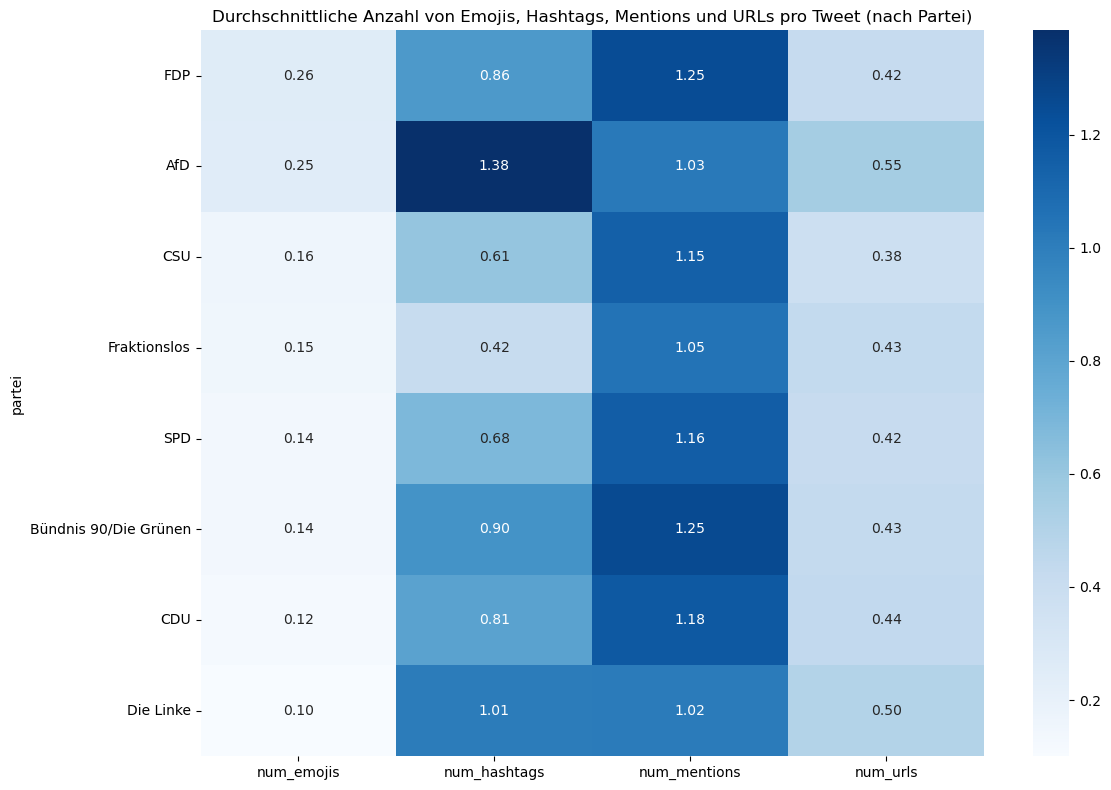

In [13]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(summary, annot=True, fmt=".2f", cmap="Blues")
plt.title("Durchschnittliche Anzahl von Emojis, Hashtags, Mentions und URLs pro Tweet (nach Partei)")
plt.tight_layout()
plt.show()

In [14]:
# Example for hashtags:
def get_top_n(pattern, n=10):
    all_matches = df["text"].str.findall(pattern).explode()
    return all_matches.value_counts().head(n)

print("\nTop 10 Hashtags insgesamt:\n", get_top_n(r"#\w+"))
print("\nTop 10 Mentions insgesamt:\n", get_top_n(r"@\w+"))


Top 10 Hashtags insgesamt:
 text
#AfD          921
#Bundestag    578
#SPD          494
#CDU          382
#Berlin       324
#Corona       320
#Merkel       304
#FDP          272
#EU           209
#CSU          201
Name: count, dtype: int64

Top 10 Mentions insgesamt:
 text
@cducsubt           543
@spdde              498
@spdbt              452
@GrueneBundestag    447
@CDU                402
@Die_Gruenen        371
@fdpbt              334
@fdp                318
@c_lindner          306
@Linksfraktion      294
Name: count, dtype: int64


## **4. Preprocessing (mit Varianten)**
Wir untersuchen verschiedene Preprocessing-Strategien. Ziel: Verschiedene Varianten vorbereiten, die wir anschließend in der Modellierung vergleichen können.

In [15]:
import pandas as pd
import re
import emoji

# Variant 1 functions
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", str(text))

def remove_mentions(text):
    return re.sub(r"@\w+", "", str(text))

def clean_hashtags(text, keep_hash=True):
    if keep_hash:
        return str(text)
    return re.sub(r"#(\w+)", r"\1", str(text))

def emoji_to_text(text, demojize=True):
    if demojize:
        return emoji.demojize(str(text), delimiters=(" ", " "))
    return str(text)

def preprocess_variant(
    text,
    lower=True,
    remove_url=False,
    remove_mention=False,
    remove_hash_symbol=False,
    demojize=False
):
    t = str(text)
    if lower:
        t = t.lower()
    if remove_url:
        t = remove_urls(t)
    if remove_mention:
        t = remove_mentions(t)
    t = clean_hashtags(t, keep_hash=not remove_hash_symbol)
    t = emoji_to_text(t, demojize=demojize)
    t = re.sub(r"\s+", " ", t).strip()
    return t


In [16]:
# Variant 2 (special token) functions
def replace_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", " URL ", str(text))

def replace_mentions(text):
    return re.sub(r"@\w+", " USER ", str(text))

def special_hashtags(text):
    # Replace #hashtag with HASHTAG_hashtag
    return re.sub(r"#(\w+)", r"HASHTAG_\1", str(text))

def preprocess_specialtok(text):
    t = str(text).lower()
    t = replace_urls(t)
    t = replace_mentions(t)
    t = special_hashtags(t)
    t = emoji_to_text(t, demojize=True)
    t = re.sub(r"\s+", " ", t).strip()
    return t

In [17]:
if __name__ == "__main__":
    df = pd.read_csv("../tweets_bundestag.csv", encoding="utf-8-sig")
    min_tweet_count = 1000
    df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
    df = df[df["partei"] != "Unbekannt"]
    df = df.sample(n=50000, random_state=42).reset_index(drop=True)

    # Save different preprocessing variants for ablation studies (Variant 1)
    variants = {
        "raw": df["text"],
        "lowercase": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=False, demojize=False, remove_hash_symbol=False)),
        "no_urls": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=True, remove_mention=False, demojize=False, remove_hash_symbol=False)),
        "no_mentions": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=True, demojize=False, remove_hash_symbol=False)),
        "no_urls_mentions": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=True, remove_mention=True, demojize=False, remove_hash_symbol=False)),
        "demojize": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=False, demojize=True, remove_hash_symbol=False)),
        "no_hashsymbol": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=False, demojize=False, remove_hash_symbol=True)),
        "no_urls_mentions_demojize": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=True, remove_mention=True, demojize=True, remove_hash_symbol=False)),
    }

    for variant, series in variants.items():
        out = df[["partei"]].copy()
        out["text"] = series
        out.to_csv(f"tweets_bundestag_{variant}.csv", index=False, encoding="utf-8-sig")
        print(f"Saved variant: {variant} to tweets_bundestag_{variant}.csv")

    print("Example cleaned texts (Variant 1):")
    print(df.head(10)[["text"]])

    # Special token variant (Variant 2)
    df["specialtok_text"] = df["text"].apply(preprocess_specialtok)
    df[["specialtok_text", "partei"]].to_csv("tweets_bundestag_specialtok.csv", index=False, encoding="utf-8-sig")
    print("Example special token cleaned texts:")
    print(df["specialtok_text"].head(10))

Saved variant: raw to tweets_bundestag_raw.csv
Saved variant: lowercase to tweets_bundestag_lowercase.csv
Saved variant: no_urls to tweets_bundestag_no_urls.csv
Saved variant: no_mentions to tweets_bundestag_no_mentions.csv
Saved variant: no_urls_mentions to tweets_bundestag_no_urls_mentions.csv
Saved variant: demojize to tweets_bundestag_demojize.csv
Saved variant: no_hashsymbol to tweets_bundestag_no_hashsymbol.csv
Saved variant: no_urls_mentions_demojize to tweets_bundestag_no_urls_mentions_demojize.csv
Example cleaned texts (Variant 1):
                                                text
0  RT @OleKreins: Aber bitte nicht das Tempelhofe...
1  @tirsales Leider wird oft vergessen, dass Face...
2  RT @SenIAS_Berlin: Arabisch, Farsi, Kurdisch, ...
3  RT @DanielGollasch: Wann wird denn der Hashtag...
4  RT @Dirk_Behrendt: Heute gedachten wir am @t4e...
5  RT @berlinliebich: Wenn doch SPD und Grüne nur...
6  RT @AndrejHunko: Drohnenangriffe: Regierung wi...
7  RT @juhessen: Heute Abend 

## **5. Modellvergleich: Verschiedene Preprocessing-Varianten**

In diesem Schritt evaluieren wir, wie sich verschiedene Text-Bereinigungsvarianten auf die Modellleistung auswirken.  
Wir verwenden als Modell:
- TF-IDF-Vektorisierung
- Logistische Regression

Kennzahlen:
- Accuracy
- F1-Score (macro & weighted)

Verglichen werden u. a.:
- Raw Text
- Ohne URLs
- Ohne Mentions
- Emojis als Text
- Spezielle Tokens wie USER / URL etc.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

variants = [
    "raw",
    "lowercase",
    "no_urls",
    "no_mentions",
    "no_urls_mentions",
    "demojize",
    "no_hashsymbol",
    "no_urls_mentions_demojize",
    "specialtok"
]

results = []

for variant in variants:
    print(f"\n=== Testing variant: {variant} ===")
    df = pd.read_csv(f"tweets_bundestag_{variant}.csv", encoding="utf-8-sig")
    df = df.dropna(subset=["text" if variant != "specialtok" else "specialtok_text"])
    text_col = "text" if variant != "specialtok" else "specialtok_text"
    min_tweet_count = 1000
    df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
    sample_size = min(50000, len(df))
    df = df.sample(n=sample_size, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col], df["partei"],
        test_size=0.2,
        random_state=42,
        stratify=df["partei"]
    )

    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {acc:.3f}, Macro F1: {macro_f1:.3f}, Weighted F1: {weighted_f1:.3f}")
    results.append({
        "variant": variant,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    })

print("\n=== Summary Table ===")
print(pd.DataFrame(results))


=== Testing variant: raw ===
Accuracy: 0.416, Macro F1: 0.387, Weighted F1: 0.431

=== Testing variant: lowercase ===
Accuracy: 0.416, Macro F1: 0.387, Weighted F1: 0.431

=== Testing variant: no_urls ===
Accuracy: 0.423, Macro F1: 0.390, Weighted F1: 0.437

=== Testing variant: no_mentions ===
Accuracy: 0.296, Macro F1: 0.277, Weighted F1: 0.306

=== Testing variant: no_urls_mentions ===
Accuracy: 0.300, Macro F1: 0.280, Weighted F1: 0.309

=== Testing variant: demojize ===
Accuracy: 0.416, Macro F1: 0.389, Weighted F1: 0.431

=== Testing variant: no_hashsymbol ===
Accuracy: 0.414, Macro F1: 0.386, Weighted F1: 0.429

=== Testing variant: no_urls_mentions_demojize ===
Accuracy: 0.308, Macro F1: 0.287, Weighted F1: 0.318

=== Testing variant: specialtok ===
Accuracy: 0.290, Macro F1: 0.274, Weighted F1: 0.300

=== Summary Table ===
                     variant  accuracy  macro_f1  weighted_f1
0                        raw  0.415600  0.387353     0.431016
1                  lowercase  0

## **6. TF-IDF Baseline**

In diesem Abschnitt trainieren wir den Baseline Modell und speichern das Modell sowie den TF-IDF-Vektorisierer mit `joblib` für spätere Nutzung.


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Choose variant here (e.g., 'raw', 'no_urls', etc.)
VARIANT = "no_urls"

df = pd.read_csv(f"tweets_bundestag_{VARIANT}.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

sample_size = min(50000, len(df))
df = df.sample(n=sample_size, random_state=42)

print("Class distribution in data:\n", df["partei"].value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["partei"],
    test_size=0.2,
    random_state=42,
    stratify=df["partei"]
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Logistic Regression with balanced class weights
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)

print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model and vectorizer for reproducibility/Streamlit
import joblib
joblib.dump(clf, f"lr_model_{VARIANT}.joblib")
joblib.dump(vectorizer, f"tfidf_{VARIANT}.joblib")

Class distribution in data:
 partei
Bündnis 90/Die Grünen    12185
SPD                      10424
CDU                       8172
Die Linke                 7071
FDP                       5005
AfD                       3619
CSU                       2185
Fraktionslos              1094
Name: count, dtype: int64
Classification report:
                       precision    recall  f1-score   support

                  AfD      0.482     0.570     0.522       724
Bündnis 90/Die Grünen      0.582     0.390     0.467      2437
                  CDU      0.463     0.386     0.421      1634
                  CSU      0.181     0.391     0.247       437
            Die Linke      0.431     0.480     0.454      1414
                  FDP      0.410     0.446     0.427      1001
         Fraktionslos      0.083     0.288     0.129       219
                  SPD      0.495     0.411     0.449      2085

             accuracy                          0.423      9951
            macro avg      0.391   

['tfidf_no_urls.joblib']

## **7. TF-IDF + Zusatzfeatures (Emojis, Hashtags, Mentions, URLs)**

Wir erweitern unser Modell um Zusatzinformationen pro Tweet:

- Anzahl Emojis
- Anzahl Hashtags
- Anzahl Mentions
- Anzahl URLs

Die Features werden standardisiert und mit dem TF-IDF-Vektor kombiniert.  
Danach folgt erneut ein Training mit logistischer Regression.

In [20]:
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import joblib

def count_emojis(text):
    return sum(char in emoji.EMOJI_DATA for char in str(text))

def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

def count_mentions(text):
    return len(re.findall(r"@\w+", str(text)))

def count_urls(text):
    return len(re.findall(r"http\S+|www\S+|https\S+", str(text)))

# Choose best variant based on previous results
VARIANT = "no_urls"
df = pd.read_csv(f"tweets_bundestag_{VARIANT}.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

# Add extra features
df["num_emojis"] = df["text"].apply(count_emojis)
df["num_hashtags"] = df["text"].apply(count_hashtags)
df["num_mentions"] = df["text"].apply(count_mentions)
df["num_urls"] = df["text"].apply(count_urls)

sample_size = min(50000, len(df))
df = df.sample(n=sample_size, random_state=42)

X_text = df["text"]
X_extra = df[["num_emojis", "num_hashtags", "num_mentions", "num_urls"]].values
y = df["partei"]

X_train_text, X_test_text, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    X_text, X_extra, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

scaler = StandardScaler(with_mean=False)
X_train_extra_scaled = scaler.fit_transform(X_train_extra)
X_test_extra_scaled = scaler.transform(X_test_extra)

X_train_combined = hstack([X_train_vec, X_train_extra_scaled])
X_test_combined = hstack([X_test_vec, X_test_extra_scaled])

clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_combined, y_train)

y_pred = clf.predict(X_test_combined)
print("Classification report (with extra features):")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

joblib.dump(clf, f"lr_model_extra_{VARIANT}.joblib")
joblib.dump(vectorizer, f"tfidf_extra_{VARIANT}.joblib")
joblib.dump(scaler, f"scaler_extra_{VARIANT}.joblib")

# Feature importances for numeric features
coef = clf.coef_
print("Numeric feature importances (per class):")
for i, col in enumerate(["num_emojis", "num_hashtags", "num_mentions", "num_urls"]):
    print(f"{col}: {coef[:, -(i+1)].mean():.4f}")

Classification report (with extra features):
                       precision    recall  f1-score   support

                  AfD      0.491     0.583     0.533       724
Bündnis 90/Die Grünen      0.582     0.389     0.466      2437
                  CDU      0.461     0.379     0.416      1634
                  CSU      0.191     0.419     0.263       437
            Die Linke      0.431     0.479     0.454      1414
                  FDP      0.406     0.455     0.429      1001
         Fraktionslos      0.081     0.283     0.126       219
                  SPD      0.503     0.410     0.452      2085

             accuracy                          0.424      9951
            macro avg      0.393     0.425     0.392      9951
         weighted avg      0.471     0.424     0.438      9951

Confusion matrix:
[[422  33  43  33  60  36  54  43]
 [104 948 196 198 338 208 166 279]
 [ 78 133 619 193 140 137 132 202]
 [ 11  44  65 183  33  24  21  56]
 [ 84 131  84  93 678  95 111 138]
 [ 

## **8. Feature Engineering (strukturierte Merkmale)**

In diesem Schritt extrahieren wir zusätzliche Merkmale aus dem Text,
die nicht durch TF-IDF oder BERT abgedeckt sind:

- Länge des Tweets (in Zeichen/Wörtern)
- durchschnittliche Wortlänge
- Verhältnis von Großbuchstaben
- Häufigkeit von !, ?, ..., Emojis, Mentions, Hashtags, URLs
- Politische Begriffe
- Retweet-Erkennung

In [21]:
import pandas as pd
import re
import emoji

# List of important political terms (example, expand as needed)
POLITICAL_TERMS = [
    "klimaschutz", "freiheit", "bürgergeld", "migration", "rente", "gerechtigkeit",
    "steuern", "digitalisierung", "gesundheit", "bildung", "europa", "verteidigung",
    "arbeitsmarkt", "soziales", "integration", "umweltschutz", "innenpolitik"
]

def count_political_terms(text):
    text = str(text).lower()
    return sum(1 for word in POLITICAL_TERMS if word in text)

def uppercase_ratio(text):
    text = str(text)
    if len(text) == 0:
        return 0
    return sum(1 for c in text if c.isupper()) / len(text)

def avg_word_length(text):
    words = re.findall(r"\w+", str(text))
    if not words:
        return 0
    return sum(len(w) for w in words) / len(words)

def multi_punct_count(text):
    return len(re.findall(r"[!?]{2,}", str(text)))

def count_emojis(text):
    return sum(1 for char in str(text) if char in emoji.EMOJI_DATA)

def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

def count_mentions(text):
    return len(re.findall(r"@\w+", str(text)))

def count_urls(text):
    return len(re.findall(r"http\S+|www\S+|https\S+", str(text)))

def count_dots(text):
    return len(re.findall(r"\.\.+", str(text)))

def is_retweet(text):
    return int(str(text).strip().lower().startswith("rt @"))

if __name__ == "__main__":
    # Use the best preprocessing variant as base
    VARIANT = "no_urls"
    df = pd.read_csv(f"tweets_bundestag_{VARIANT}.csv", encoding="utf-8-sig")
    df = df[df["text"].notna() & (df["text"].str.strip() != "")]
    df = df.reset_index(drop=True)

    # Feature extraction
    df["tweet_length_chars"] = df["text"].apply(len)
    df["tweet_length_words"] = df["text"].apply(lambda x: len(str(x).split()))
    df["avg_word_length"] = df["text"].apply(avg_word_length)
    df["uppercase_ratio"] = df["text"].apply(uppercase_ratio)
    df["exclamations"] = df["text"].apply(lambda x: str(x).count("!"))
    df["questions"] = df["text"].apply(lambda x: str(x).count("?"))
    df["multi_punct_count"] = df["text"].apply(multi_punct_count)
    df["political_term_count"] = df["text"].apply(count_political_terms)
    df["num_emojis"] = df["text"].apply(count_emojis)
    df["num_hashtags"] = df["text"].apply(count_hashtags)
    df["num_mentions"] = df["text"].apply(count_mentions)
    df["num_urls"] = df["text"].apply(count_urls)
    df["dots"] = df["text"].apply(count_dots)
    df["is_retweet"] = df["text"].apply(is_retweet)

    # Save engineered features for downstream use
    df.to_csv("tweets_bundestag_features.csv", index=False, encoding="utf-8-sig")
    print("Feature file saved as tweets_bundestag_features.csv")

Feature file saved as tweets_bundestag_features.csv


## **9. Kombiniertes Modell: BERT + strukturierte Features**

In diesem Schritt kombinieren wir zwei Informationsquellen:

- **Textrepräsentation** über vortrainiertes `bert-base-german-cased` (CLS-Embedding)
- **Strukturierte Merkmale** aus dem vorherigen Feature Engineering (z. B. Emojis, Wortlänge, Großschreibung, politische Begriffe etc.)

Ziel ist es, die Vorhersagegenauigkeit durch die Kombination von Kontext (BERT) und Stil/Merkmalen zu verbessern.


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
import warnings

warnings.filterwarnings("ignore")

# 1. Load features extracted in 07
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
df = df.reset_index(drop=True)
sample_size = min(50000, len(df))
df = df.sample(n=sample_size, random_state=42)

# 2. BERT tokenizer and model (German BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()  # Eval mode

def embed_texts(texts, max_len=128, batch_size=32):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            # CLS token embedding (batch_size, hidden_size)
            cls_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_emb)
    return np.vstack(embeddings)

X_text = df["text"].tolist()
y = df["partei"]

# 3. Numeric features to use
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
X_numeric = df[feature_cols].values

# (Optional) Balanced sampling: Max 1000 per party
sample_per_party = 1000
df_balanced = (
    df.groupby("partei", group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
      .reset_index(drop=True)
)
X_text_bal = df_balanced["text"].tolist()
X_numeric_bal = df_balanced[feature_cols].values
y_bal = df_balanced["partei"]

# Train/test split on balanced data
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text_bal, X_numeric_bal, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

# 4. Compute BERT embeddings (can be cached if slow)
X_text_train_emb = embed_texts(X_text_train)
X_text_test_emb = embed_texts(X_text_test)

# 5. Scale numeric features
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

# 6. Combine BERT and numeric features
X_train_combined = np.hstack([X_text_train_emb, X_num_train_scaled])
X_test_combined = np.hstack([X_text_test_emb, X_num_test_scaled])

# 7. Train Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
clf.fit(X_train_combined, y_train)

y_pred = clf.predict(X_test_combined)
print("\nClassification report (combined features):")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model and scaler for reproducibility/Streamlit
joblib.dump(clf, "lr_model_combined.joblib")
joblib.dump(scaler, "scaler_combined.joblib")


Classification report (combined features):
                       precision    recall  f1-score   support

                  AfD      0.390     0.425     0.407       200
Bündnis 90/Die Grünen      0.191     0.195     0.193       200
                  CDU      0.224     0.180     0.199       200
                  CSU      0.357     0.410     0.381       200
            Die Linke      0.274     0.260     0.267       200
                  FDP      0.284     0.290     0.287       200
         Fraktionslos      0.336     0.355     0.345       200
                  SPD      0.192     0.175     0.183       200

             accuracy                          0.286      1600
            macro avg      0.281     0.286     0.283      1600
         weighted avg      0.281     0.286     0.283      1600


Confusion matrix:
[[85 23 13 18 10 13 23 15]
 [15 39 19 28 31 31 19 18]
 [20 28 36 31 20 21 21 23]
 [14 16 24 82 15 11 15 23]
 [25 27 16 13 52 20 19 28]
 [20 26 17 13 21 58 23 22]
 [18 23 10 18 23

['scaler_combined.joblib']

## 10. **Klassifikation mit TF-IDF, BERT und Feature Engineering (Random Forest)**

In diesem Abschnitt kombinieren wir drei Arten von Features:

- **TF-IDF-Repräsentationen** der Tweets  
- **BERT-Embeddings** aus dem `bert-base-german-cased` Modell  
- **Manuell extrahierte Features** (z. B. Anzahl Emojis, Großbuchstaben, Hashtags etc.)

Das Modell zur Klassifikation ist ein **Random Forest**, der alle kombinierten Features berücksichtigt.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModel

# Load features
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

# For a quick, balanced test, sample up to 1000 tweets per party
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

Number of tweets used: 8000


In [25]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df_sample["text"])

In [26]:
# BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()
def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

Calculating BERT embeddings (this may take several minutes)...


In [27]:
# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

In [28]:
# Combine all features
X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

                       precision    recall  f1-score   support

                  AfD      0.382     0.585     0.462       200
Bündnis 90/Die Grünen      0.190     0.160     0.174       200
                  CDU      0.186     0.150     0.166       200
                  CSU      0.304     0.325     0.314       200
            Die Linke      0.200     0.160     0.178       200
                  FDP      0.362     0.295     0.325       200
         Fraktionslos      0.264     0.380     0.311       200
                  SPD      0.186     0.130     0.153       200

             accuracy                          0.273      1600
            macro avg      0.259     0.273     0.260      1600
         weighted avg      0.259     0.273     0.260      1600



## **11. Klassifikation mit TF-IDF, BERT und Feature Engineering (Logistic Regression)**

In diesem letzten Abschnitt kombinieren wir erneut:

- **TF-IDF-Vektoren**
- **BERT-Embeddings**
- **Feature-Engineering (z. B. Emojis, Hashtags, Großschreibung, etc.)**

Diesmal kommt ein **Logistic Regression-Modell** (mit `saga`-Solver) zum Einsatz.


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModel

# Load features and sample as before...
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)
print(f"Number of tweets used: {len(df_sample)}")

vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df_sample["text"])

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()
def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)
print("Calculating BERT embeddings...")
X_bert = embed_texts(df_sample["text"].tolist())

feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)


Number of tweets used: 8000
Calculating BERT embeddings...


In [30]:
clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1, solver='saga')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

                       precision    recall  f1-score   support

                  AfD      0.464     0.510     0.486       200
Bündnis 90/Die Grünen      0.234     0.250     0.242       200
                  CDU      0.258     0.235     0.246       200
                  CSU      0.345     0.355     0.350       200
            Die Linke      0.249     0.230     0.239       200
                  FDP      0.356     0.310     0.332       200
         Fraktionslos      0.283     0.310     0.296       200
                  SPD      0.225     0.225     0.225       200

             accuracy                          0.303      1600
            macro avg      0.302     0.303     0.302      1600
         weighted avg      0.302     0.303     0.302      1600

